In [1]:
import torch
import numpy as np
import imutils
import time
import cv2

from PIL import Image, ImageOps
from torchvision import transforms

from imutils.object_detection import non_max_suppression

import matplotlib.pyplot as plt
import torch.nn as nn

import models.MathNet as mnt
import models.MathNet112 as mnt56
from utils.letter import Letter

In [2]:
MODEL_PATH = 'models\mathnet224\mathnet8.ml'

In [3]:
#CUDA_LAUNCH_BLOCKING=1
torch.cuda.empty_cache()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
(H, W) = (400, 400)
class SlidingWindowObjectDetection():
    def __init__(self, pretrained_classifier_path, kwargs):
        self.model = mnt.MathNet()
        self.model.load_state_dict(torch.load(pretrained_classifier_path))
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.model = self.model.to(device)
        self.kwargs = kwargs
    
    def test(self, image, step, ws):
        potential = []
        for y in range(0, image.shape[0] - ws[1], step):
            for x in range(0, image.shape[1] - ws[0], step):
                crop_img = image[y:y+28, x:x+28]
                #print(type(image), type(crop_img))
                crop_tensor = transforms.ToTensor()
                
               
                
                thresh = 120
                ret,thresh_img = cv2.threshold(crop_img, thresh, 255, cv2.THRESH_BINARY)

                #find contours
                contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                img_contours = np.uint8(np.zeros((crop_img.shape[0],crop_img.shape[1])))
                cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
                
                if (len(contours) > 1):
                    #print(x,y, len(contours))
                    #img = Image.fromarray(crop_img.astype('uint8'))
                    #img = Image.fromarray(img_contours.astype('uint8'))
                    #display(img)
                    potential.append(crop_img)
        return potential
    
    def predict(self, lst):
        res = []
        for image in lst:
            img = Image.fromarray(image.astype('uint8'))
            convert_tensor = transforms.Compose([
                transforms.Resize((28,28)),
                transforms.Grayscale(1),
                transforms.ToTensor()

            ])

            
            x_image = convert_tensor(img)
            x_image = x_image.unsqueeze(0).float()
            x_image = x_image.to(device)

            preds = self.model(x_image) 
            prob = preds.max()
            if prob >= self.kwargs['MIN_CONF']:
                print(prob.item(), (map_pred(preds.argmax()), preds))
                img = Image.fromarray(image.astype('uint8'))
                display(img)
            
                res.append((map_pred(preds.argmax()), preds))

        
    def visualize_rois(self, rois):
        fig, axes = plt.subplots(1, len(rois), figsize=(20, 6))
        for ax, roi in zip(axes, rois):
            ax.imshow(roi, cmap='gray')

    
    def get_preds(self, rois, locs):
        rois = np.array(rois, dtype="float32")
        preds = self.predict(rois)
        #preds = list(zip(preds.argmax(axis=1).tolist(), preds.max(axis=1).tolist()))
        res = []
        for i in range(0, len(preds)):
            res.append((map_pred(preds[i].argmax()), preds[i].max()))
        #print(res)
        labels = {}

        for (i, p) in enumerate(res):
            (label, prob) = p
            if prob >= self.kwargs['MIN_CONF']:
                box = locs[i]
                L = labels.get(label, [])
                L.append((box, prob))
                labels[label] = L
        return preds, labels
    
    def __call__(self, img):
        potential = self.test(img, self.kwargs['WIN_STEP'], self.kwargs['ROI_SIZE'])
        self.predict(potential)
        
        rois, locs = self.get_rois_and_locs()
        
        preds, labels = self.get_preds(rois, locs)
        nms_labels = self.apply_nms(labels)
        if self.kwargs['VISUALIZE']:
            self.visualize_preds(img, nms_labels)
        return nms_labels



In [5]:
kwargs = dict(
    PYR_SCALE=1.25,
    WIN_STEP=3,
    ROI_SIZE=(21, 21),
    INPUT_SIZE=(28, 28),
    VISUALIZE=True,
    MIN_CONF=0.4
)

In [6]:
IMAGE_NAME = 'TEST/5.jpg'
image = cv2.imread(IMAGE_NAME)

img_grey = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

#set a thresh
thresh = 120

#get threshold image
ret,thresh_img = cv2.threshold(img_grey, thresh, 255, cv2.THRESH_BINARY)

#find contours
contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img_contours = np.uint8(np.zeros((image.shape[0],image.shape[1])))



In [7]:
cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
1

1

In [8]:
sw = SlidingWindowObjectDetection(MODEL_PATH, kwargs)
IMAGE_NAME = 'TEST/5.jpg'
image = cv2.imread(IMAGE_NAME)
img_grey = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
print('END')


END


In [9]:
def resize_letter(image, dst):
    return None

In [29]:
def letters_extract(image_file):
    img = cv2.imread(image_file)
    output = img.copy()
    cv2.imshow('MyPhoto', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    thresh = 100
    thresh_img = cv2.adaptiveThreshold(gray, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,5,8)
    ret,thresh_img = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY)
    cv2.imshow('thresh_img', thresh_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    img_erode = thresh_img#cv2.erode(thresh_img, np.ones((3, 3), np.uint8), iterations=3)
#     cv2.imshow('MyPhoto', img_erode)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    

    # Get contours
    contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)       
    img_contours = np.uint8(np.zeros((img.shape[0],img.shape[1])))
    cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
    cv2.imshow('img_contours', img_contours )
    cv2.waitKey(0)
    cv2.destroyAllWindows()
       
    # Filter contours
    mask = np.uint8(np.zeros((img.shape[0],img.shape[1])))
    for idx, contour in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)
        if cv2.contourArea(contour) > 10 and cv2.contourArea(contour) < 10000:
            cv2.drawContours(mask, [contour], 0, (255), -1)
        else:
            pass
#             dummy = np.uint8(np.zeros((img.shape[0],img.shape[1])))
#             cv2.drawContours(dummy, contour, -1, (255,255,255), 1)
#             print(w*h, cv2.contourArea(contour))
#             cv2.imshow(str(idx), dummy )
#             cv2.waitKey(0)
#             cv2.destroyAllWindows()
            
#     # apply the mask to the original image
    result = cv2.bitwise_and(img,img, mask= mask)   
    cv2.imshow('result', result )
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    img_contours = np.uint8(np.zeros((img.shape[0],img.shape[1])))
    cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
    cv2.imshow('Contours', img_contours )
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    letters = []
    for idx, contour in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)
        #print("R", idx, x, y, w, h, cv2.contourArea(contour), hierarchy[0][idx])
        if hierarchy[0][idx][3] != -1:
            continue
#         mask_contour = img_contours[y:y+h, x:x+w]
#         mask_contour[y_pos:y_pos + h, 0:w] = crop_img
#         cv2.drawContours(mask_contour, contour, -1, (255,255,255), 1)
#         cv2.imshow('MyPhoto', mask_contour)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()

#         cv2.imwrite('mask.png', img * max(img - 100, 0) * 255)
#         ii = cv2.imread('mask.png')
#         cv2.imshow('MyPhoto', ii )
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()
        crop_img = img_erode[y:y+h, x:x+w]
        #crop_img = thresh_img[y:y+h, x:x+w]
        size_max = max(w, h)
        letter_square = 255 * np.ones(shape=[size_max, size_max], dtype=np.uint8)
        if w > h:
            y_pos = size_max//2 - h//2
            letter_square[y_pos:y_pos + h, 0:w] = crop_img
        elif w < h:
            x_pos = size_max//2 - w//2
            letter_square[0:h, x_pos:x_pos + w] = crop_img
        else:
            letter_square = crop_img
        #letter_square = cv2.dilate(letter_square, np.ones((3, 3), np.uint8), iterations=1)
        x,y,w,h = cv2.boundingRect(contour)
        rect = cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255,0), 2)      
        inverted = cv2.bitwise_not(letter_square)
        
        letter = Letter(x,y,w,h,letter_square)
        letters.append(letter)

    letters.sort(key=lambda ll: (ll.y, ll.x), reverse=False)
    aaa = Image.fromarray(output.astype('uint8'))
    display(aaa)
    return letters

In [12]:
def average_size(lst):
    if len(lst) <= 0:
        return (0, 0)
    avg_w = 0
    avg_h = 0
    for letter in lst:
        avg_w += letter.width
        avg_h += letter.height
    avg_w /= len(lst)
    avg_h /= len(lst)
    
    return (avg_w, avg_h)

In [31]:
def img_to_str(model, image_file, tp=1):
    letters = letters_extract(image_file)   
    
    print('SHAPE: ', np.array(letters,dtype=object).shape)
    s_out = ""
    if len(letters) == 0:
        return "Found nothing"
    (avg_w, avg_h) = average_size(letters)
    print((avg_w, avg_h))
    
    # True sorting by Y axis
    line = 0
    for i in range (1, len(letters)):
        if letters[i].top > letters[i-1].bottom:
            line += 1
        letters[i].line = line
    letters.sort(key=lambda ll: (ll.line, ll.x), reverse=False)  
    
    prev_loc = (letters[0].x, letters[0].y)
    prev_size = (letters[0].width, letters[0].height)
    prev_line = letters[0].line
    #for i in range(1):
    for i in range(len(letters)):
        
        img = Image.fromarray(letters[i].image.astype('uint8'))
        convert_tensor = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.Grayscale(1),
            transforms.ToTensor()

        ])        
        x_image = convert_tensor(img)
        aaa = transforms.ToPILImage()
        display(aaa(x_image))
        x_image = x_image.unsqueeze(0).float()
        x_image = x_image.to(device)
        pred = model(x_image) 
        prob = pred.max().item()
        if prob > 0.75:
            am = mnt.map_pred(pred.argmax().item())
            #print(letters[i].image.shape, map_pred(pred.argmax().item()), am)
            #dn = letters[i+1][0] - letters[i][0] - letters[i][1] if i < len(letters) - 1 else 0
            #print(am)
            x = letters[i].x
            y = letters[i].y
            size = (letters[i].width, letters[i].height)
            if (letters[i].line >  prev_line):
                s_out += "\n"
                prev_line = letters[i].line
            prev_loc, prev_size = (x,y), size
            s_out += am + ' '
            print(letters[i].image.shape, am, prob)
        
    return s_out

In [22]:
model = mnt.MathNet()
model.load_state_dict(torch.load(MODEL_PATH))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()
print('EVALUATION')

EVALUATION


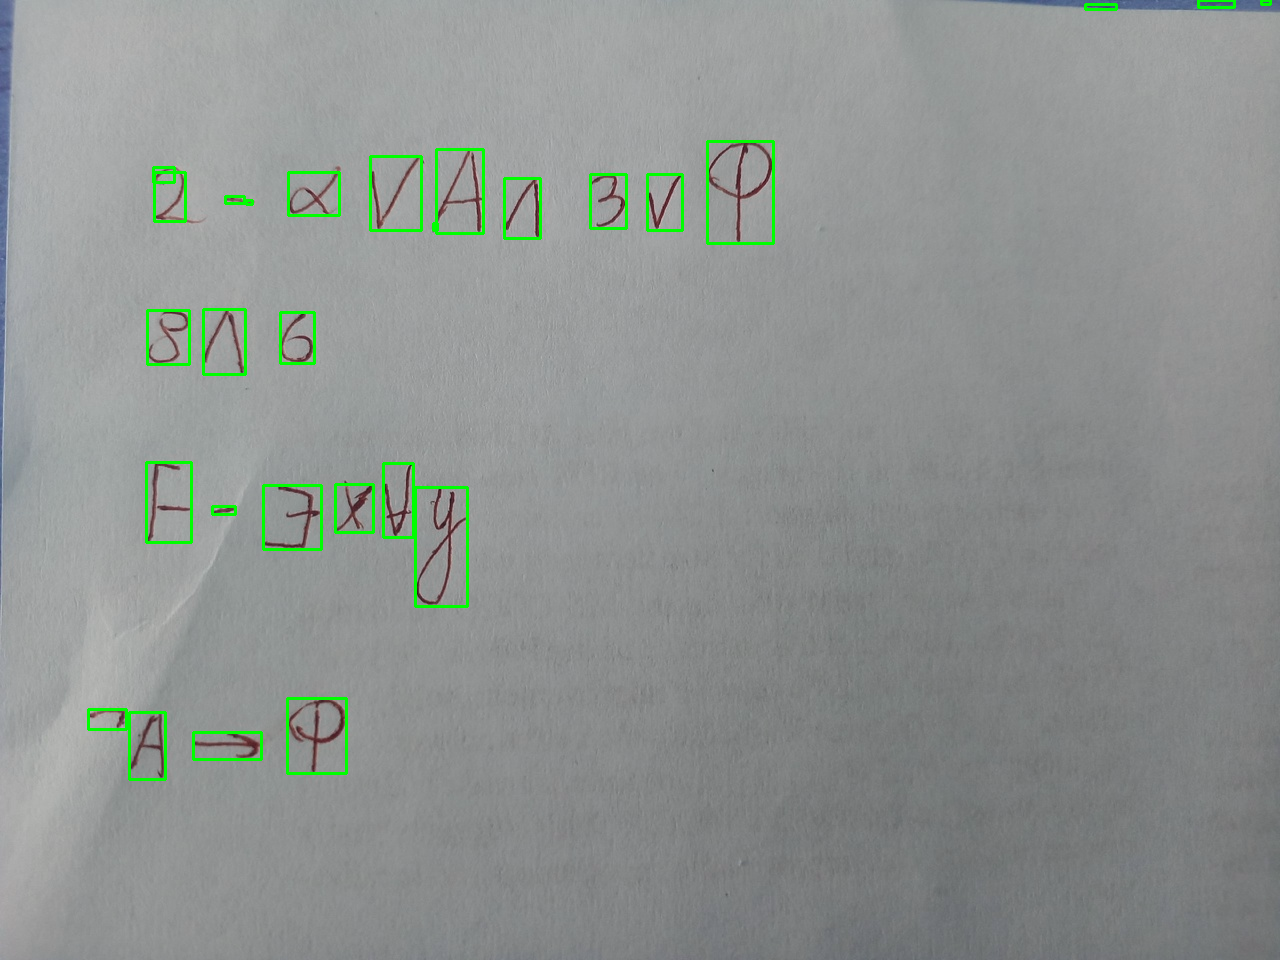

SHAPE:  (28,)
(37.285714285714285, 47.25)


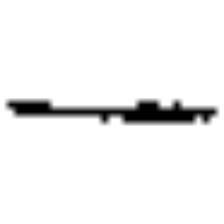

(31, 31) rightarrow 4.111947536468506


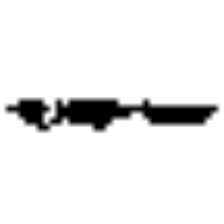

(36, 36) rightarrow 5.028433799743652


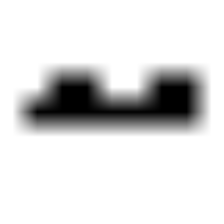

(9, 9) rightarrow 3.078705072402954


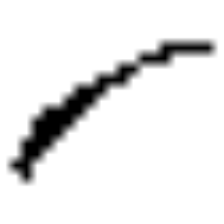

(21, 21) tau 1.6027237176895142


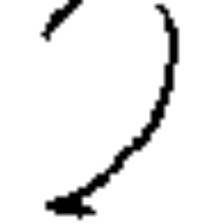

(49, 49) ) 4.605037689208984


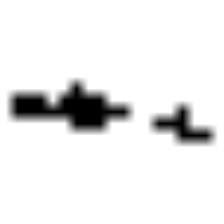

(19, 19) rightarrow 4.2886786460876465


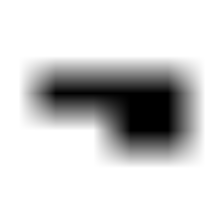

(6, 6) not 4.076852798461914


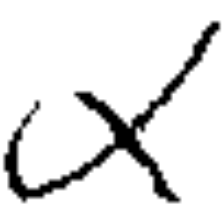

(51, 51) alpha 4.991640090942383


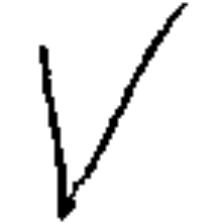

(74, 74) upsilon 7.293241500854492


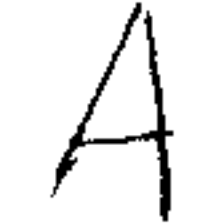

(84, 84) theta 3.5447585582733154


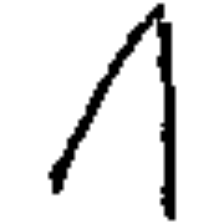

(60, 60) and 5.303014278411865


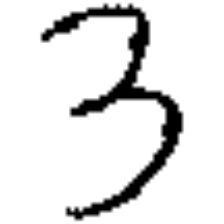

(54, 54) z 5.777559280395508


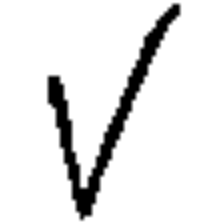

(56, 56) upsilon 4.668182373046875


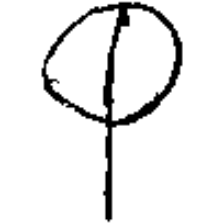

(102, 102) phi 6.949427127838135


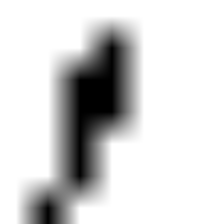

(7, 7) mu 3.835597276687622


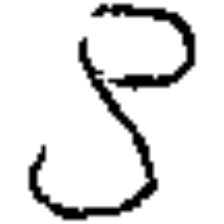

(54, 54) delta 5.719234943389893


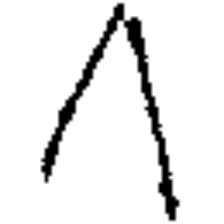

(65, 65) and 6.288768768310547


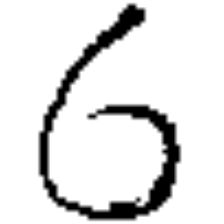

(51, 51) sigma 4.5467753410339355


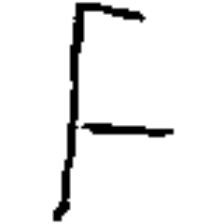

(80, 80) F 11.773885726928711


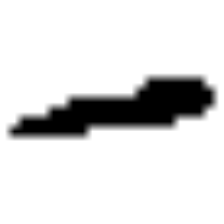

(23, 23) rightarrow 5.8044257164001465


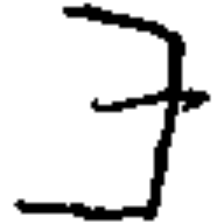

(64, 64) z 3.4604198932647705


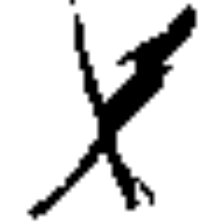

(48, 48) lambda 6.847291469573975


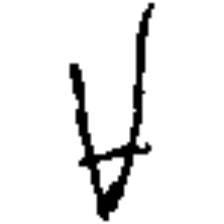

(74, 74) forall 3.7511954307556152


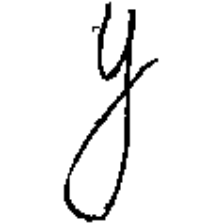

(119, 119) y 6.331295013427734


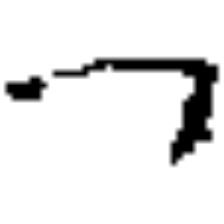

(38, 38) not 7.10455846786499


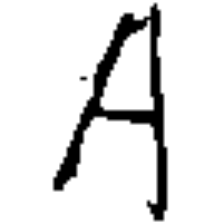

(67, 67) A 4.576803207397461


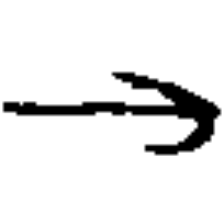

(68, 68) rightarrow 11.18049144744873


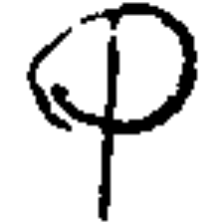

(75, 75) phi 7.7836527824401855
RESULT:
rightarrow rightarrow rightarrow 
tau ) rightarrow not alpha upsilon theta and z upsilon phi 
mu 
delta and sigma 
F rightarrow z lambda forall y 
not A rightarrow phi 


In [32]:
s = img_to_str(model, 'TEST/real5.jpg', 1)
print('RESULT:')
print(s)

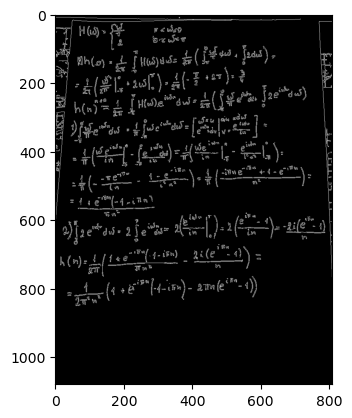

-1

In [16]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('TEST/h.jpg')
edges = cv2.Canny(img,25,255,L2gradient=False)
cv2.imshow('Start image', img)
plt.imshow(edges, cmap='gray')
plt.show()
cv2.waitKey(0)

In [17]:
# import os
# from os import makedirs
# from os.path import isfile, join, exists

# def custom_sort(countour):
#     return -cv2.contourArea(countour)

# def remove_isolated_pixels(image):
#     connectivity = 8

#     output = cv2.connectedComponentsWithStats(image, connectivity, cv2.CV_32S)

#     num_stats = output[0]
#     labels = output[1]
#     stats = output[2]

#     new_image = image.copy()

#     for label in range(num_stats):
#         if stats[label,cv2.CC_STAT_AREA] == 1:
#             new_image[labels == label] = 0

#     return new_image

# symbol = 'sigma'
# path = r'E:\Download\Query\\' + symbol + '\\'
# onlyfiles = [f for f in os.listdir(path) if os.path.isfile(join(path, f))]
# if not os.path.exists(path + 'new\\'):
#     makedirs(path + 'new\\')
# for i, file in enumerate(onlyfiles):
#     img = cv2.imread(path + '\\' + file)
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     # Get contours
    
#     for x in range(0, img.shape[1]):
#         gray[img.shape[0]-6][x] = 255
#     for x in range(0, 3):    
#         for y in range(0, img.shape[0]):
#             gray[y][x] = 255
#             gray[y][ img.shape[1] - 1 - x] = 255

#     gray = cv2.bitwise_not(gray)
#     gray =  cv2.bitwise_not(remove_isolated_pixels(gray))
#     #gray = cv2.erode(gray, np.ones((3, 3), np.uint8), iterations=1)
#     cv2.imwrite(path + 'new\\' + symbol + '-' + str(i) + '.jpg', gray)

#     # cv2.imshow('result', img )
#     # cv2.waitKey(0)
#     # cv2.destroyAllWindows()

In [18]:
# import os
# from os import makedirs
# from os.path import isfile, join, exists

# symbol = '_h'
# #path = r'G:\TRAIN\extracted_images\\' + symbol + '\\'
# #path = r'G:\TRAIN\hasy_sorted\\' + symbol + '\\'
# #path = r'G:\TRAIN\by_class\\' + symbol + '\\'
# #path = r'E:\Download\Query\\' + symbol + '\\'
# path = r'E:\TRAIN\emnist\\' + symbol + '\\'
# onlyfiles = [f for f in os.listdir(path) if isfile(join(path, f))]
# if not os.path.exists(path + 'sized\\'):
#     makedirs(path + 'sized\\')

# for i, file in enumerate(onlyfiles):
#     img = cv2.imread(path + '\\' + file)
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     gray = cv2.resize(gray, (224, 224), interpolation = cv2.INTER_AREA)

#     #cv2.imwrite(path + 'sized\\' + symbol + '-' + str(i) + '.jpg', gray)
#     gray = cv2.flip(gray, 0)
#     #gray = cv2.rotate(gray, cv2.ROTATE_90_CLOCKWISE)
#     cv2.imwrite(path + 'sized\\' + symbol + '-' + str(i) + '-mirror.jpg', gray)
    
#     # gray = cv2.erode(gray, np.ones((3, 3), np.uint8), iterations=1)
#     # cv2.imwrite(path + 'sized\\' + symbol + '-' + str(i) + 'erode.jpg', gray)  
#     # cv2.imshow('result', img )
#     # cv2.waitKey(0)
#     # cv2.destroyAllWindows()

16384
16243
0.99139404296875
12 (104, 104) (128, 128) (128, 128)


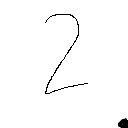

In [8]:
img = Image.open("TEST/0.jpg")
roiOrig = cv2.imread("TEST/0.jpg")
roiOrig = cv2.cvtColor(roiOrig,cv2.COLOR_BGR2GRAY)

def add_border(image):
    pad = int(image.shape[0]*0.2 / 2)
    mask1 = np.uint8(np.ones((int(image.shape[0] - 2 * pad), int(image.shape[1] - 2 * pad))) * 255.0)
    mask2 = np.pad(mask1, pad_width=pad)
    print(pad, mask1.shape, mask2.shape, roiOrig.shape)
    mask1 = np.uint8(np.ones((int(image.shape[0]), int(image.shape[1])))* 255.0)
    res = cv2.bitwise_and(mask2, image)
    res = cv2.bitwise_or(cv2.bitwise_not(mask2), res)
    return res


# skip blank images   
area = img.size[0]*img.size[1]    
print(area)
print(cv2.countNonZero(roiOrig))
print(cv2.countNonZero(roiOrig) / area)
roiOrig = add_border(roiOrig)
cv2.imshow("aa", roiOrig)
cv2.waitKey(0)
if (cv2.countNonZero(roiOrig) / area < 0.99):         
#if (img.size[0]*img.size[1] - cv2.countNonZero(roiOrig) != 0):
    roi = cv2.resize(roiOrig, (224, 224))
    roi = cv2.dilate(roi, np.ones((3, 3), np.uint8), iterations=1)
    print('ok')
display(img)
img.close()

EVALUATION


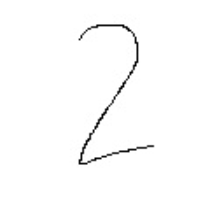

tensor([[-1.0619e+01, -1.6338e+01, -4.2907e+01, -1.5791e+01, -1.0251e+01,
          1.9200e+01,  3.6434e+01, -9.6683e+00, -9.7900e+00, -1.7779e+01,
          2.9977e+00, -4.3045e+01, -1.7595e+01, -1.8244e+01, -1.1025e+01,
         -5.1935e+01, -3.3400e+01, -1.9851e+01, -4.8845e+01, -5.0866e+01,
         -4.6350e+01, -6.0360e+01, -6.4183e+01, -4.5088e+01, -4.1541e+01,
         -6.9921e+01, -7.0943e+01, -4.7931e+01, -4.8031e+01, -1.0000e+03,
         -6.9892e+01, -2.8993e+01, -6.1896e+01, -6.2610e+01, -8.4424e+01,
         -4.1407e+01, -6.0595e+01, -4.3860e+01, -3.6251e+01, -4.9168e+01,
         -5.2854e+01, -3.1789e+01,  9.7969e-01]], device='cuda:0',
       grad_fn=<MulBackward0>) 2


In [22]:
import cv2
from PIL import Image, ImageOps

model = mnt.MathNet()
model.load_state_dict(torch.load(MODEL_PATH))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()
print('EVALUATION')

img = Image.open("TEST/0.jpg")
#print(img.shape)
convert_tensor = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(1),
    transforms.ToTensor()

])        
x_image = convert_tensor(img)

aaa = transforms.ToPILImage()
display(aaa(x_image))

x_image = x_image.unsqueeze(0).float()
x_image = x_image.to(device)

pred = model(x_image) 
pred[0][29] = -100
print(pred*10, mnt.map_pred(pred.argmax().item()))